In [2]:
import numpy as np
import pandas as pd 
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib notebook

The following query was run to select faint sources where the pm and parallax signal is likely not real:

    select top 100000000
    sqrt(power(pmra,2) + power(pmdec,2)) as pm, 
    sqrt( power(pmra,2)*power(pmra_error, 2)/sqrt(power(pmra,2) + power(pmdec,2)) + power(pmdec,2)*power(pmdec_error, 2)/sqrt(power(pmra,2) + power(pmdec,2)) + 2*pmra*pmdec/sqrt(power(pmra,2) + power(pmdec,2))*pmra_pmdec_corr*pmra_error*pmdec_error) as pm_unc, gaia.parallax_over_error, gaia.b
    from  gaiadr2.gaia_source as gaia
    where gaia.phot_g_mean_mag between 20.5 and 21 and gaia.astrometric_params_solved > 3

In [3]:
faint = fits.getdata("faint-result.fits")

In [4]:
faint

FITS_rec([(3.0516611796350133, 3.7639480416855817, 0.18210286, 39.139631570454334),
       (4.4419234694254026, 3.4909513841453506, -0.26111981, 39.531858289030971),
       (5.9006320093404021, 4.442049806749063, -1.2223487, 38.89264692741429),
       ...,
       (10.037986651560391, 6.8991297953232911, -1.5586098, 6.913531448501061),
       (4.0803432302208806, 5.1146135102669126, 1.1336904, 6.8115298340698782),
       (14.353267746762196, 11.68204976315808, 0.76749605, 6.6037767590230763)], 
      dtype=(numpy.record, [('pm', '>f8'), ('pm_unc', '>f8'), ('parallax_over_error', '>f4'), ('b', '>f8')]))

In [5]:
np.percentile(faint['pm']/faint['pm_unc'], (0.003, 50, 99.997))

array([ 0.07736103,  1.08090107,  8.19051634])

In [6]:
np.percentile(faint['parallax_over_error'], (0.003, 50, 99.997))

array([ -9.97694493,   0.24908522,  11.00686075])

## Cuts for selecting stars

The above analysis suggests that selecting sources with a **PM SNR > 8** and a **parallax SNR > 11** will overwhelmingly select real stars for the ZTF star-galaxy catalog. 

Below we investigate whether there is any significant bias associated with parallax or proper motion measurements as a function of crowding (where we use galactic latitude as a proxy for crowding).

<IPython.core.display.Javascript object>


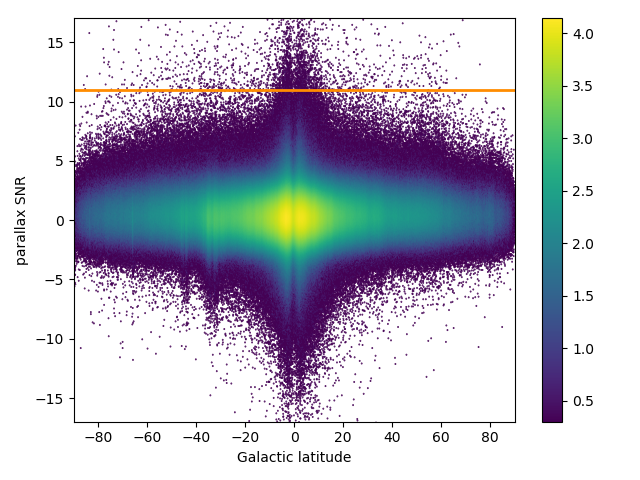

In [14]:
fig, ax = plt.subplots()
hax = ax.hexbin(faint["b"], faint["parallax_over_error"],
                bins="log", mincnt=1, gridsize=1000,
                extent=(-90,90,-25,25))
ax.plot([-90,90], [11,11], 'DarkOrange', lw=2)

ax.set_xlim(-90,90)
ax.set_ylim(-17,17)
ax.set_xlabel("Galactic latitude")
ax.set_ylabel("parallax SNR")

fig.colorbar(hax)
fig.tight_layout()

In [11]:
b = faint["b"]
pm_snr = faint["pm"]/faint["pm_unc"]

<IPython.core.display.Javascript object>


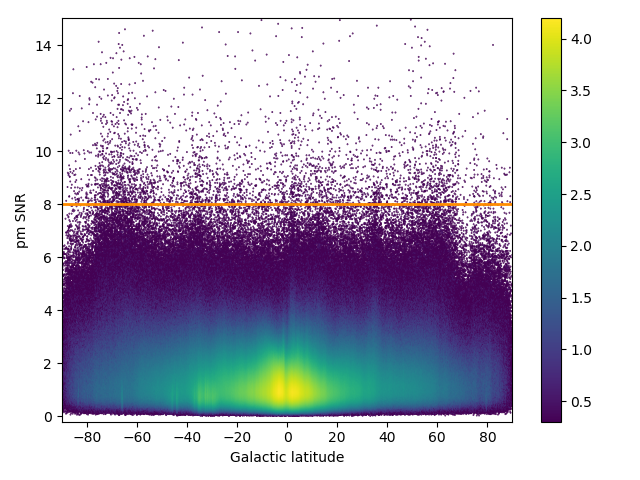

In [15]:
fig, ax = plt.subplots()
hax = ax.hexbin(b, pm_snr,
                bins="log", mincnt=1, gridsize=1000,
                extent=(-90,90,0,20))
ax.plot([-90,90], [8,8], 'DarkOrange', lw=2)

ax.set_xlim(-90,90)
ax.set_ylim(-0.2,15)
ax.set_xlabel("Galactic latitude")
ax.set_ylabel("pm SNR")

fig.colorbar(hax)
fig.tight_layout()

## ALLWISE AGN

In addition to looking at faint stars, a conservative cut could be made using QSOs (which should have negligible parallax and proper motion). 

In [Lindegren et al 2018](https://arxiv.org/pdf/1804.09366.pdf), Gaia DR2 is matched to ALLWISE QSOs away from the Galactic plane. Those sources can be selected from Gaia via the following cut: 

    select sqrt(power(pmra,2) + power(pmdec,2)) as pm, 
    sqrt( power(pmra,2)*power(pmra_error, 2)/sqrt(power(pmra,2) + power(pmdec,2)) + power(pmdec,2)*power(pmdec_error, 2)/sqrt(power(pmra,2) + power(pmdec,2)) + 2*pmra*pmdec/sqrt(power(pmra,2) + power(pmdec,2))*pmra_pmdec_corr*pmra_error*pmdec_error) as pm_unc, gaia.parallax_over_error, pmra/pmra_error as pmra_over_error, pmdec/pmdec_error as pmdec_over_error
    from  gaiadr2.gaia_source as gaia 
    join  gaiadr2.aux_allwise_agn_gdr2_cross_id as allwise
    on allwise.source_id = gaia.source_id

In [12]:
allwise = fits.getdata("QSOcat-result.fits")

In [13]:
np.percentile(allwise['pm']/allwise['pm_unc'], (0.003, 50, 99.997))

array([ 0.07882897,  1.24706007,  9.12542682])

In [14]:
np.percentile(allwise['parallax_over_error'], (0.003, 50, 99.997))

array([-4.86143718, -0.07854312,  4.69923397])

The QSO sample was selected to remove sources with `parallax_over_error` > 5, thus this particular selection cannot help us with a selection of sources. 